In [9]:
#import numpy, scipy, math and astropy libraries
import numpy as np
import scipy as sp
import math
import astropy
from astropy.io import ascii
from astropy.table import Table, Column
import pandas as pd
import csv


#import graphics packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.colorbar as cb

#set plotting defaults to values that make plots look publication ready
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 11
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

#ensure that plots show up in our notebook (comment this out if converting to a script)
%matplotlib notebook


In [3]:
#opening the list of APOGEE type 1 IDs
with open('/Volumes/CoveyData/APOGEE_Spectra/Anna/clean_IDs_list.csv') as csvfile:
    LCData = csv.reader(csvfile, delimiter = ',')
    listID = [0]
    for row in LCData:
        IDs = row[0]
        listID.append(IDs)
    del(listID[0])  
    listID[0] = '2M00224443+8448486'

#opening the list of the periods of the APOGEE IDs    
with open('/Volumes/CoveyData/APOGEE_Spectra/Anna/periods.csv') as csvfile:
    period = csv.reader(csvfile, delimiter = ',')
    days = []
    IDList = []
    for this in period:
        Apogee=this[0]
        IDList.append(Apogee)
        periods = this[1]
        days.append(periods)

14.12 14.031


(14.5, 13.5)

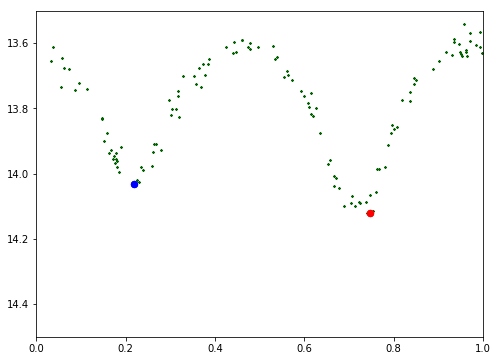

In [4]:
#read in the light curve
LC = Table.read("/Volumes/CoveyData/APOGEE_Spectra/Anna/Light_curves/2M04403927+3306187.LC.csv", data_start=1, delimiter=',')
#LC.info()

#define the period and calculate phase
period = 0.40158
phase = Column((LC['hjd'] % period) / period, name='phase')

#compute a simpler JD
simpleJD = Column(np.asarray(LC['hjd']) - np.ones(len(LC['hjd']))*2457000., name='simpleJD')

#create a flag column; later we can get fancy if we want to omit some points
flag = Column(np.ones(len(LC['hjd'])), name='flag')

#create a version of the table to output for ellc
LC.add_column(simpleJD, index=0)
LC.remove_columns(['hjd', 'camera','filter','flux (mJy)', 'flux err'])
LC.add_column(flag)
LC.add_column(phase)

#LC.info()

#write out light curve in format that ellc can read in for fitting
#ascii.write(LC, '2M04403927+3306187.dat')

#find the location of the maximum magnitude value (which corresponds to the deepest eclipse)
primary_eclipse = np.argmax(LC['mag'])
phase_of_primary_eclipse = LC['phase'][primary_eclipse]
mag_of_primary_eclipse = LC['mag'][primary_eclipse]

#now search for phases that are within 0.2 of this phase, and create a copy of the magnitude 
#array that has the values within 0.2 in phase set them to -99.
mags_for_secondary = np.where( (LC['phase'] > phase_of_primary_eclipse - 0.2) & (LC['phase'] < phase_of_primary_eclipse + 0.2), -99, LC['mag'])

#now search this new magnitude array for its' maximum -- since the values near the primary have been 
#'masked' to -99., they won't be identified as the maximum, so we should usually get the secondary eclipse
secondary_eclipse = np.argmax(mags_for_secondary)
phase_of_secondary_eclipse = LC['phase'][secondary_eclipse]
mag_of_secondary_eclipse = LC['mag'][secondary_eclipse]

print(mag_of_primary_eclipse, mag_of_secondary_eclipse)

fig=plt.figure(1,figsize=(8,6))

plt.scatter(LC['phase'],LC['mag'],color='darkgreen',marker='x',s=3)
plt.scatter([phase_of_primary_eclipse, phase_of_primary_eclipse], [mag_of_primary_eclipse, mag_of_primary_eclipse],color='red',marker='o',s=40)
plt.scatter([phase_of_secondary_eclipse, phase_of_secondary_eclipse], [mag_of_secondary_eclipse, mag_of_secondary_eclipse],color='blue',marker='o',s=40)
plt.xlim([0,1.0])
plt.ylim([14.5,13.5])

#plt.savefig('2M0440_LC_MarkPrimary+Secondary.jpg', bbox_inches='tight') 
#plt.show()

In [18]:
def LightCurveEclipse(listofIDs):
    i=0
    #for loop that goes through all light curve files
    for x in listofIDs: 
        #read in the light curve
        LC = Table.read("/Volumes/CoveyData/APOGEE_Spectra/Anna/Light_curves/"+x+".LC.csv", data_start=1, delimiter=',')

        #define the period and calculate phase
        period = float(days[i])
        phase = Column((LC['hjd'] % period) / period, name='phase')
        i = i+1
        #compute a simpler JD
        simpleJD = Column(np.asarray(LC['hjd']) - np.ones(len(LC['hjd']))*2457000., name='simpleJD')

        #create a flag column; later we can get fancy if we want to omit some points
        flag = Column(np.ones(len(LC['hjd'])), name='flag')

        #create a version of the table to output for ellc
        LC.add_column(simpleJD, index=0)
        LC.remove_columns(['hjd', 'camera','filter','flux (mJy)', 'flux err'])
        LC.add_column(flag)
        LC.add_column(phase)

        #LC.info()

        #write out light curve in format that ellc can read in for fitting
        #ascii.write(LC, '2M04403927+3306187.dat')

        #find the location of the maximum magnitude value (which corresponds to the deepest eclipse)
        primary_eclipse = np.argmax(LC['mag'])
        phase_of_primary_eclipse = LC['phase'][primary_eclipse]
        mag_of_primary_eclipse = LC['mag'][primary_eclipse]

        #now search for phases that are within 0.2 of this phase, and create a copy of the magnitude 
        #array that has the values within 0.2 in phase set them to -99.
        mags_for_secondary = np.where( (LC['phase'] > phase_of_primary_eclipse - 0.2) & (LC['phase'] < phase_of_primary_eclipse + 0.2), -99, LC['mag'])

        #now search this new magnitude array for its' maximum -- since the values near the primary have been 
        #'masked' to -99., they won't be identified as the maximum, so we should usually get the secondary eclipse
        secondary_eclipse = np.argmax(mags_for_secondary)
        phase_of_secondary_eclipse = LC['phase'][secondary_eclipse]
        mag_of_secondary_eclipse = LC['mag'][secondary_eclipse]
        
        
                           
LightCurveEclipse(listID)

SyntaxError: invalid syntax (<ipython-input-18-b787438e9b49>, line 46)